In [2]:
from keras.models import Model
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image

import numpy as np
import scipy as sp
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [3]:
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
print(resnet.summary())

102858752/102853048 [==============================] - 12s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
_________________________________________

In [4]:
# make a model to get output before flatten
activation_layer = resnet.get_layer('activation_49')

In [5]:
# create a model object
model = Model(inputs=resnet.input, outputs=activation_layer.output)

In [8]:
# get the feature map weights
final_dense = resnet.get_layer('fc1000')
W = final_dense.get_weights()[0]

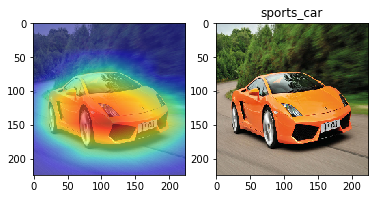

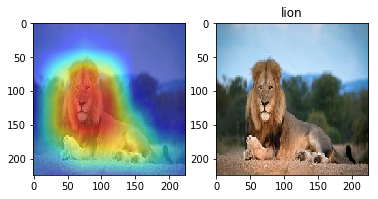

In [25]:
images = ['./data/car.jpg', './data/lion.jpeg']
for path in images:
    img = image.load_img(path, target_size=(224, 224))
    x = preprocess_input(np.expand_dims(img, axis=0))
    
    fmaps = model.predict(x)[0]  # shape 7x7x2048
    
    # get predicted class from resnet model
    probs = resnet.predict(x)
    classnames = decode_predictions(probs)[0]
    classname = classnames[0][1]
    pred = np.argmax(probs[0])
    
    # get the 2048 weights for the relevant class
    w = W[:, pred]
    
    # "dot" w with fmaps
    cam = fmaps.dot(w)
    
    # upsample to 224 x 224
    # 7 x 32 = 224
    cam = sp.ndimage.zoom(cam, (32, 32), order=1)
    plt.subplot(1,2,1)
    plt.imshow(img, alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.title(classname)
    plt.show()